In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from network import Modele

%load_ext autoreload
# Load the TensorBoard notebook extension

%autoreload 2

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
#Simple Dataset class for our change detection dataset

class ChangeDetectionDataset(Dataset):
    def __init__(self, csv_file="data.csv", data_dir="./data", batch_size=1, transform=None, crop_size=128):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.crop_size = crop_size
    def __len__(self):
        return len(self.data)

    def random_crop(self, img1, img2, cm, size):
        x = np.random.randint(0, img1.shape[2]-size)
        y = np.random.randint(0, img1.shape[1]-size)
        img1 = img1[:,y:y+size, x:x+size]
        img2 = img2[:,y:y+size, x:x+size]
        cm = cm[0:1, y:y+size, x:x+size]
        return img1, img2, cm

    def random_flip(self, img1,img2,cm, chance=0.5):
        if (np.random.randint(0,1)> chance):
            img1= img1[:,-1:1, :]
            img2= img2[:,-1:1, :]
            cm= cm[:,-1:1, :]

        if (np.random.randint(0,1)> chance):
            img1= img1[:,:,-1:1]
            img2= img2[:,:,-1:1]
            cm= cm[:,:,-1:1]

    def __getitem__(self, idx):
        img1 = read_image(self.data_dir+'/'+self.data.iloc[idx,0])
        img2 = read_image(self.data_dir+'/'+self.data.iloc[idx,1])
        cm = read_image(self.data_dir+'/'+self.data.iloc[idx,2])


        img1Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        img2Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        cmTensor = torch.zeros((1, self.crop_size, self.crop_size), dtype=torch.float32)

        
        crop1, crop2, cropcm = self.random_crop(img1[:,:,:], img2[:,:,:], cm[:,:,:], self.crop_size)
        img1Tensor[:,:,:] = crop1.float()/255
        img2Tensor[:,:,:] = crop2.float()/255
        cmTensor[:,:,:] = cropcm.float()
        #apply the same transformation to all images as batch dimension
        return img1Tensor, img2Tensor, cmTensor
        

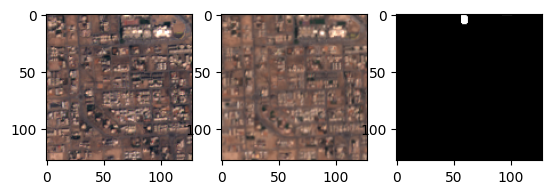

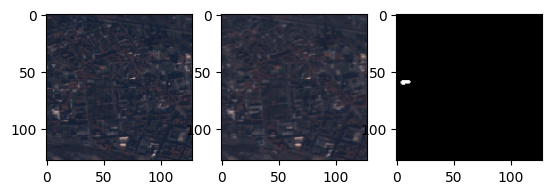

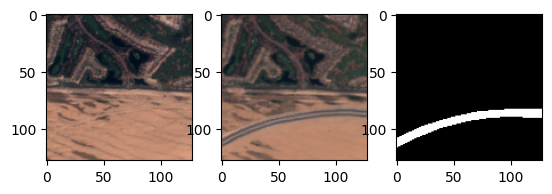

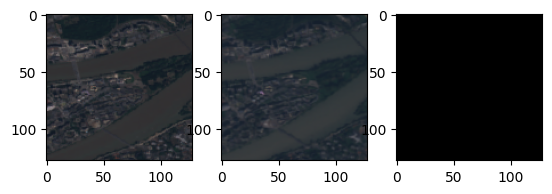

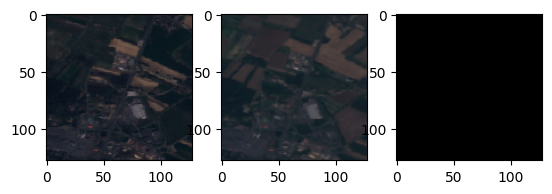

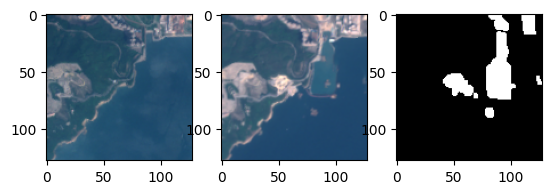

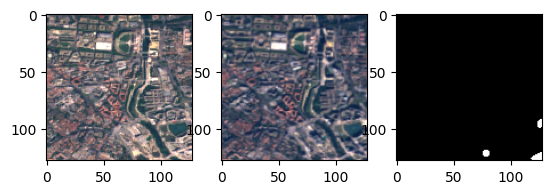

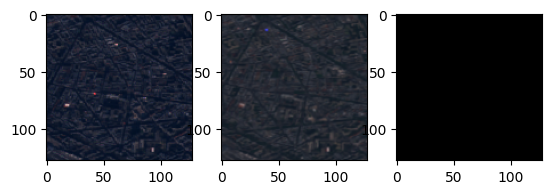

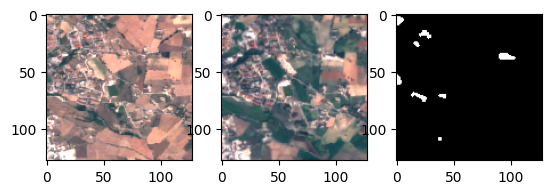

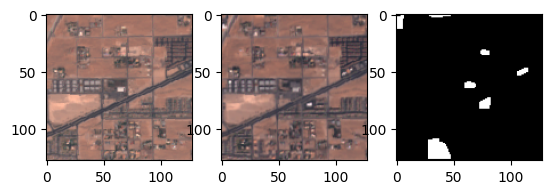

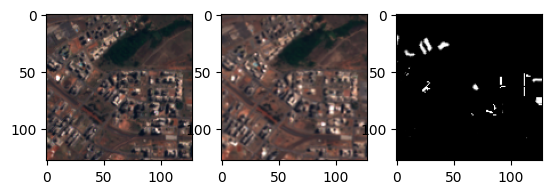

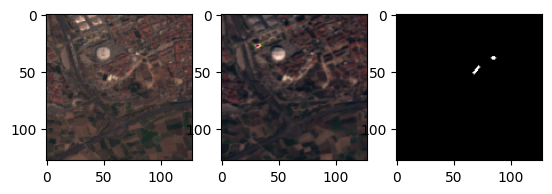

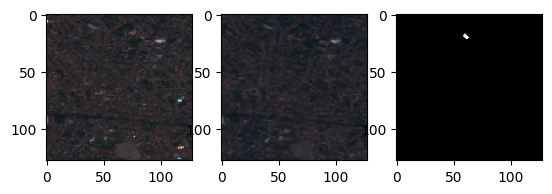

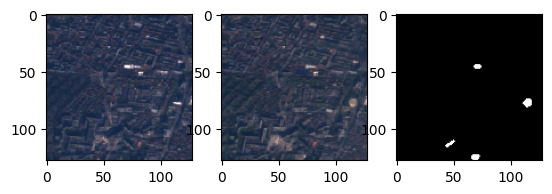

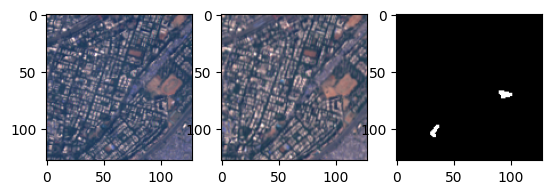

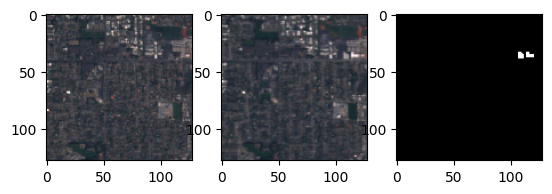

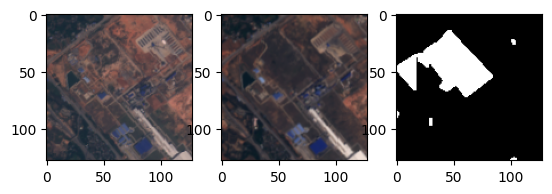

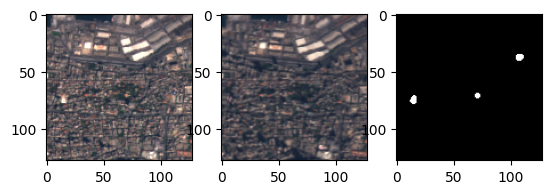

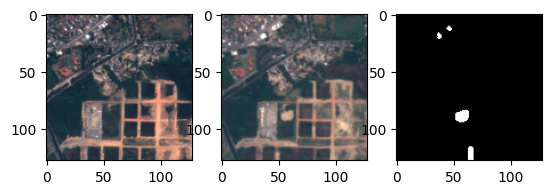

In [4]:
#Simple DataLoader class for our change detection dataset
batch_size = 32

train_dataset= ChangeDetectionDataset(data_dir="data",csv_file="train.csv", batch_size=batch_size, transform=None)
val_dataset = ChangeDetectionDataset(data_dir="data",csv_file="val.csv", batch_size=1, transform=None)
train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=True)
#Simple function to display a batch of images

def show_batch(batch):
    img1s, img2s, cms = batch

    for i in range(len(img1s)):
        img1 = img1s[i,:,:,:]
        img2 = img2s[i,:,:,:]
        cm = cms[i,:,:,:]
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img1.permute(1,2,0))
        ax[1].imshow(img2.permute(1,2,0))
        ax[2].imshow(cm.permute(1,2,0), cmap='gray')
        plt.show()

#a = next(iter(train_loader))
#show_batch(a)

In [5]:
n_epoch = 100
learning_rate = 0.000001
model = Modele()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss, val_loss = [], []
model = model.to(device)
best_loss =1000

for epoch in range(n_epoch):
    model.train()
    accu = 0

    for img1,img2,cm in train_loader:
        img1,img2,cm = img1.to(device),img2.to(device),cm.to(device)
        #Forward pass
        y_pred = model(img1, img2)
        loss = loss_fn(y_pred, cm)
        accu += loss.item()
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu/len(train_loader))

    model.eval()
    with torch.no_grad():
        accu=0
        for img1,img2,cm in val_loader:
            img1,img2,cm = img1.to(device),img2.to(device),cm.to(device)
            y_pred=model(img1,img2)
            loss = loss_fn(y_pred,cm)
            accu += loss.item()
            if(accu/len(val_loader) < best_loss):
                best_loss = accu/len(val_loader)
                torch.save(model.state_dict(), "best_model.pt")
        val_loss.append(accu/len(val_loader))
    print(f"Train {epoch+1}: {train_loss[-1]} and Valid {epoch}: {val_loss[-1]}")

Train 1: 4.546436309814453 and Valid 0: 6.2515869140625
Train 2: 9.592944145202637 and Valid 1: 10.4869873046875
Train 3: 4.643369197845459 and Valid 2: 7.4980224609375
Train 4: 6.139298439025879 and Valid 3: 15.1998779296875
Train 5: 9.424572944641113 and Valid 4: 7.299586391448974
Train 6: 8.016139030456543 and Valid 5: 6.310534822940826
Train 7: 5.264735698699951 and Valid 6: 9.612702441215514
Train 8: 21.599414825439453 and Valid 7: 3.7030566453933718
Train 9: 6.766005516052246 and Valid 8: 8.881158351898193
Train 10: 8.055925369262695 and Valid 9: 12.009841704368592
Train 11: 5.850513935089111 and Valid 10: 9.746713566780091
Train 12: 5.974640846252441 and Valid 11: 9.719763326644898
Train 13: 12.168434143066406 and Valid 12: 8.585911059379578
Train 14: 8.620518684387207 and Valid 13: 7.470695281028748
Train 15: 8.711009979248047 and Valid 14: 4.157290458679199
Train 16: 4.168636322021484 and Valid 15: 4.654830265045166
Train 17: 10.748101234436035 and Valid 16: 5.815798926353454


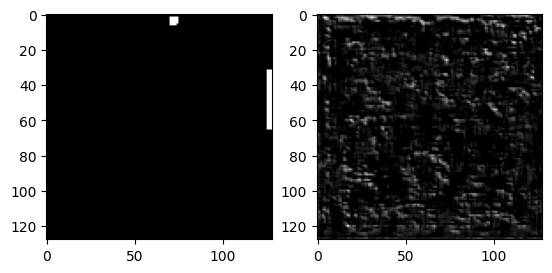

In [6]:
model.cpu()

im1,im2,cm = next(iter(val_loader))
cm_pred = model(im1,im2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(cm[0].permute(1,2,0), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cm_pred.detach()[0].permute(1,2,0), cmap='gray')